<h3>Descriptive Data</h3>

Here we have some basic data about the passengers on the Titanic, written in longhand.

In [1]:
import unicodecsv
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot
import seaborn as sns
%pylab inline
%matplotlib inline
titanicdata = pd.read_csv("titanic-data.csv", skipinitialspace=True)

#function for descriptive statistics of the data set
def description(x):
    print ('Average', str(x),':', titanicdata[x].mean())
    print ('Median', str(x), ':', titanicdata[x].median())
    print ('Minimum', str(x), ':', titanicdata[x].min())
    print ('Maxiumum', str(x), ':', titanicdata[x].max())
    print ('Range of', str(x), ':', titanicdata[x].max() - titanicdata[x].min())
    print ('Standard deviation of', str(x), ':', titanicdata[x].std())
    print ('')

description('Age')
description('Fare')
print ('Survived:', titanicdata.Survived.sum())
print ('Died:', (len(titanicdata) - titanicdata.Survived.sum()))
print ('Odds of survival:',(titanicdata.Survived.sum()) / (len(titanicdata) - titanicdata.Survived.sum()\
                                                           + titanicdata.Survived.sum()) )
print ()
print ('Sex:', titanicdata['Sex'].value_counts())
print ()
print ('Embarked:', titanicdata['Embarked'].value_counts())


Populating the interactive namespace from numpy and matplotlib
Average Age : 29.69911764705882
Median Age : 28.0
Minimum Age : 0.42
Maxiumum Age : 80.0
Range of Age : 79.58
Standard deviation of Age : 14.526497332334044

Average Fare : 32.2042079685746
Median Fare : 14.4542
Minimum Fare : 0.0
Maxiumum Fare : 512.3292
Range of Fare : 512.3292
Standard deviation of Fare : 49.693428597180905

Survived: 342
Died: 549
Odds of survival: 0.3838383838383838

Sex: male      577
female    314
Name: Sex, dtype: int64

Embarked: S    644
C    168
Q     77
Name: Embarked, dtype: int64


We can also use titanic.describe():

In [2]:
titanicdata.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

<h3> Questions </h3>

The most compelling question is also the same one suggested in the project details, and perhaps the most commonly tackled in this project: Which factors correlate with an increased change of survival? For this project, we'll focus on two factors: how fare price may have impacted survival rates, and how age may have impacted survival rates.

First, let's take a look at whether we need to do any data cleaning.

In [3]:
titanicdata.isnull().any(axis=0)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

It looks like there are no null values in the fare column. However, because survival is a discrete variable, we'll still have to clean it up a bit shortly. And because we're examining age, we'll clean it up in that portion of the analysis.

<h3> Question 1: Fares and Survival </h3>

Let's get a bird's-eye view of things first.

In [4]:
#vectorized functions for cursory descriptive statistics about survival rates vis-a-vis fare
fare = pd.Series(titanicdata['Fare'], index = titanicdata['PassengerId'])
survived = pd.Series(titanicdata['Survived'])
above_avg_fare = titanicdata[titanicdata.Fare > titanicdata.Fare.mean()]
survivors = titanicdata[titanicdata.Survived == 1]
rich_survivors = titanicdata[(titanicdata.Fare > titanicdata.Fare.mean()) & titanicdata.Survived == 1]
richsurvivorrate = len(rich_survivors) / len(above_avg_fare)

print ('Number of passengers paying more than average:', len(above_avg_fare))
print ('Number of survivors:', len(survivors))
print ('Number of high paying survivors:', len(rich_survivors))
print ('Percentage of high paying survivors to high payers:', richsurvivorrate)
print ('Overall survival rate:', (len(survivors) / len(titanicdata)))

Number of passengers paying more than average: 211
Number of survivors: 342
Number of high paying survivors: 126
Percentage of high paying survivors to high payers: 0.5971563981042654
Overall survival rate: 0.3838383838383838


Passengers paying above-average fares had roughly a 21 percent higher survival rate than passengers at large. There are a few kinds of tests we can run to test this hypothesis. First, we can run a simple binomial hypothesis test (p > 0.01).

In [5]:
scipy.stats.binom_test(126, n=211, p=0.38)

2.2437341531282312e-10

As we can see, the odds that the above-average payers could have randomly survived at the rate they did is astronomically small. But there are more tests we can run to investigate further. Because survival is a discrete values of 0 or 1, and because the fare data is highly positively skewed, we can conduct a Chi-square test to measure correlations between variables. However, because fare is a continuous variable, we have to convert it to a discrete variable as well by standardizing. The challenge is to convert the fares into discrete groups that actually reflect differences in those groups, something that confronts the challenge of the number of low-paying passengers, as seen here:

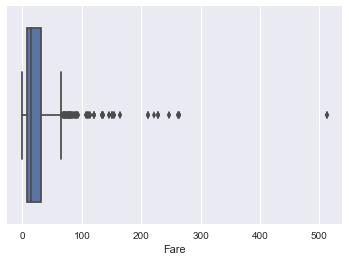

In [6]:
sns.boxplot(x=titanicdata.Fare, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, \
            palette=None, saturation=0.75, width=0.8, fliersize=5, linewidth=None, whis=1.5, notch=False, ax=None)

Converting to quintiles produces too much overlap in groups; thus, we'll add a new row with quartiles.

In [7]:
titanicdata['Farequartile'] = pd.qcut(titanicdata.Fare, 4, labels = False)

First, let's get a straightforward sense of things. What do the different rates look like?

In [8]:
'''
This is a function to compute surival rates based on fare quartile, allowing us to plug in a quartile for the variable x.
The function adds each computed number to the array histnum, which can be called upon for easily inserting into data viz
functions later.
'''

histnum = []

def survivorrate(x):
    survivorratenum = len(titanicdata[(titanicdata.Farequartile == x) & titanicdata.Survived == 1]) / \
    len(titanicdata[(titanicdata.Farequartile == x)])
    histnum.append(survivorratenum)
    print ('Quartile', str(x), 'survival rate:', survivorratenum)

survivorrate(0)
survivorrate(1)
survivorrate(2)
survivorrate(3)

Quartile 0 survival rate: 0.19730941704035873
Quartile 1 survival rate: 0.30357142857142855
Quartile 2 survival rate: 0.45495495495495497
Quartile 3 survival rate: 0.581081081081081


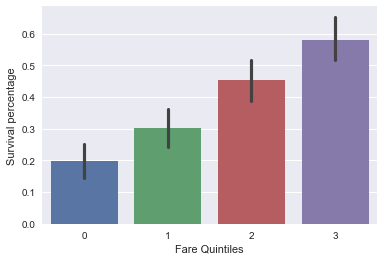

In [9]:
barplot = sns.barplot(x="Farequartile", y='Survived', data=titanicdata)
barplot.set(xlabel = 'Fare Quintiles', ylabel = 'Survival percentage')

The relationship between fare quartiles and survival rate is so strikingly linear that we should expect there to be a significant statistic for Pearson's R (which we can conduct because the quartiles are ordinal, not nominal), which there is:

In [10]:
scipy.stats.pearsonr(titanicdata.Fare, titanicdata.Survived)

(0.25730652238496243, 6.1201893419218733e-15)

But we'll go ahead with our Chi-squared test anyway. Let's organize our observed values. Our expected value is .3838, as calculated above.

In [11]:
#with assistance from https://discussions.udacity.com/t/unpaired-t-test-on-survival-probability-by-sex/208154

OverallRate = titanicdata['Survived'].mean()
observed = titanicdata.groupby('Farequartile').sum()['Survived']
expected = titanicdata.groupby('Farequartile').count()['Survived'] * OverallRate

print (observed)
print (expected)

Farequartile
0     44
1     68
2    101
3    129
Name: Survived, dtype: int64
Farequartile
0    85.595960
1    85.979798
2    85.212121
3    85.212121
Name: Survived, dtype: float64


In [12]:
scipy.stats.chisquare(observed, expected)

Power_divergenceResult(statistic=49.400098917151084, pvalue=1.0721302396929389e-10)

We shouldn't expect Chi-square to give the exact same p-value as Pearson's R, but they should be more or less in the same ballpark of probability, as they are here. As expected, the p-value is significant here at p < 0.0001.

<h3>Question 2: Age and Survival </h3>

Because there are null values in the age column, we need to delete the null values. We can in fact create a separate dataframe that simply deletes all rows with a null age value, allowing us to easily work with the cleaned data without having to create individual series.

In [13]:
titanicdataclean = titanicdata[~titanicdata.Age.isnull()]
titanicdataclean.count()

PassengerId     714
Survived        714
Pclass          714
Name            714
Sex             714
Age             714
SibSp           714
Parch           714
Ticket          714
Fare            714
Cabin           185
Embarked        712
Farequartile    714
dtype: int64

Now, we can essentially complete the same steps of computation that we conducted in the analysis of fare.

In [14]:
titanicdataclean['Agequartile'] = pd.qcut(titanicdataclean.Age, 4, labels = False)

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
titanicdataclean

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
18            19         0       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25            26         1       3   
27            28         0       1   
30            31         0       1   
33            34         0       2   
34            35         0       1   
35            36         0       1   
37            38         0       3   
38            39         0       3   
..           ...       ...     ...   
856          857         1       1   
857          858         1       1   
858          859         1       3   
860          861         0       3   
861          862         0       2   
862          863         1       1   
864          865         0       2   
865          866         1       2   
866          867         1       2   
867          868         0       1   
869          870         1       3   
870          871         0       3   
871          872         1       1   
872          873         0       1   
873          874         0       3   
874          875         1       2   
875          876         1       3   
876          877         0       3   
877          878         0       3   
879          880         1       1   
880          881         1       2   
881          882         0       3   
882          883         0       3   
883          884         0       2   
884          885         0       3   
885          886         0       3   
886          887         0       2   
887          888         1       1   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
6                              McCarthy, Mr. Timothy J    male  54.0      0   
7                       Palsson, Master. Gosta Leonard    male   2.0      3   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                  Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                     Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                            Bonnell, Miss. Elizabeth  female  58.0      0   
12                      Saundercock, Mr. William Henry    male  20.0      0   
13                         Andersson, Mr. Anders Johan    male  39.0      1   
14                Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   
15                    Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
16                                Rice, Master. Eugene    male   2.0      4   
18   Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0      1   
20                                Fynney, Mr. Joseph J    male  35.0      0   
21                               Beesley, Mr. Lawrence    male  34.0      0   
22                         McGowan, Miss. Anna "Annie"  female  15.0

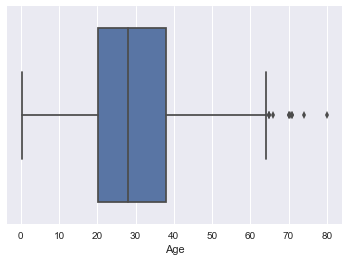

In [16]:
sns.boxplot(x=titanicdataclean.Age, y=None, hue=None, data=None, order=None, hue_order=None, \
            orient=None, color=None, palette=None, saturation=0.75, width=0.8, fliersize=5, \
            linewidth=None, whis=1.5, notch=False, ax=None)

In [17]:
'''
The same function as used above with the fare quartiles, modified to calculate age.
'''

histnumAge = []

def survivorrateAge(x):
    survivorrateAgenum = len(titanicdataclean[(titanicdataclean.Agequartile == x) & titanicdataclean.Survived == 1]) / \
    len(titanicdataclean[(titanicdataclean.Agequartile == x)])
    histnumAge.append(survivorrateAgenum)
    print ('Quartile', str(x), 'survival rate:', survivorrateAgenum)

survivorrateAge(0)
survivorrateAge(1)
survivorrateAge(2)
survivorrateAge(3)

Quartile 0 survival rate: 0.4581005586592179
Quartile 1 survival rate: 0.36065573770491804
Quartile 2 survival rate: 0.4342857142857143
Quartile 3 survival rate: 0.3728813559322034


Numerally, there doesn't seem to be much of a differnce. And if we create a histogram, we see it's pretty flat.

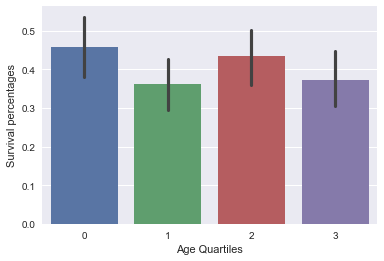

In [18]:
barplotage = sns.barplot(x="Agequartile", y='Survived', data=titanicdataclean)
barplotage.set(xlabel = 'Age Quartiles', ylabel = 'Survival percentages')

In [19]:
OverallRateAge = titanicdataclean['Survived'].mean()
observedAge = titanicdataclean.groupby('Agequartile').sum()['Survived']
expectedAge = titanicdataclean.groupby('Agequartile').count()['Survived']  * OverallRateAge

print (observedAge)
print (expectedAge)

Agequartile
0    82
1    66
2    76
3    66
Name: Survived, dtype: int64
Agequartile
0    72.703081
1    74.327731
2    71.078431
3    71.890756
Name: Survived, dtype: float64


In [20]:
#chi-square test as conducted above, modified for age quartiles
scipy.stats.chisquare(observedAge, expectedAge)

Power_divergenceResult(statistic=2.9453569273641347, pvalue=0.40012701985887833)

At p = .4, the relation between age and survival is not statistically significant.

In [21]:
titanicdata.corr()

PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId      1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived        -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass          -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age              0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp           -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch           -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare             0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   
Farequartile    -0.022998  0.299357 -0.634271  0.086846  0.393025  0.393881   

                  Fare  Farequartile  
PassengerId   0.012658     -0.022998  
Survived      0.257307      0.299357  
Pclass       -0.549500     -0.634271  
Age           0.096067      0.086846  
SibSp         0.159651      0.393025  
Parch         0.216225      0.393881  
Fare          1.000000      0.579345  
Farequartile  0.579345      1.000000

<h3>Conclusion</h3>

The relationship between fare-price and survival is significant at p < 0.0001. For survival and age, the relationship is not significant, with p = .4. Further tests could explore how particular fares are associated with particular increase or decrease in the odds of survival. The tests do not imply causation among correlated data points.

Except that they most certainly do. Analysis of any data is inherently limited---we are always barred from traveling back in time, from entering the minds of the very humans whose lives are the foundation of unanimated numbers, from returning to what Karl Popper deemed the illusory "original source". These data are no different: it is imperfect by virtue of absent values and an incomplete accounting of all the Titanic's survived and perished. However, the dataset is not nearly as limited as both the rubric and reviewers seem to insist. For one, 891 passengers is a quarter of the Titanic's total 3,547 passengers, and even the cleaned data set for the age analysis is more than 20 percent of the total passenger load. The values absent from the dataset would have to be improbably, almost impossibly, skewed for these findings not to manifest in the full Titanic passenger list.

But more importantly, the fare analysis is not only a reiteration of past scholarly studies into how class dynamics manifested in the Titanic disaster, but also reflects indisputable realities about early 20th Century life. As one academic noted,<blockquote>So little attention was paid to [the connection between price and survival] because before the First World War social class was so much taken for granted that the reduced survival among third class passengers was unremarkable. It was just assumed that the price of a first class passage included an increased chance of surviving a sinking. Provided there was no evidence of explicit discrimination between the classes in the allocation of positions in the lifeboats the class differences in survival were regarded as a reflection of the natural order. (Hall W. <i>Social Science and Medicine</i> 1986 22 (6): 687-690.) </blockquote>

The rubric's insistence that causal links not be drawn between data in this set reflects a dogma of neutrality throughout contemporary statistics that smacks of spineless intellectual nonconfrontation, something Popper himself would have declared profoundly unscientific. This positition precludes both engagement with working truths that already exist, and creative, explanatory conjectures while those truths remain obscured. Instead, the rubric seems to give no hint of where the exit might lie from guarded, risk-free statements about p values. In fact, more than 100 years after the Titanic, we have no evidence that higher fare price did **not** cause a higher chance of survival, and we have no other evidence largely because it is difficult to imagine an alternative mechanism by which wealthier people survived the incident in such large, unlikely numbers. To insist we avoid even the mere gesture of causality is a form of analysis so bashful as to verge on the autistic.

I would urge Udacity to reconsider this silly clause in the conclusions component of the Project 2 rubric, lest we encourage students to become mere technicians of noncommital p-values.
